In [1]:
import pyomo.environ as pyo 
from pyomo.environ import *
from pyomo.opt import SolverFactory
import pandas as pd
import os
os.chdir('C:\\Users\\omkarp\\Downloads\\Optimize\\')

# Assignment: Biodiesel supply chain

1. Formulate a model maximizing the profit from the production

**Sets:** 
- Crops: {soybeans, sunflower seeds, cotton seeds} 
- Products: {B5, B30, B100}

**Parameters for the model:**
- Yield_Crop (tonnes/ha) = [2.6, 1.4, 0.9] (expected yield of crop in tonnes per hectare)
- WaterDemand_cop (Ml/ha) = [5.0, 4.2, 1.0] (water demand of crop in megaliters per hectare)
- OilContent_crop (l/kg) = [178, 216, 433] (oil content of crop in liters per tonne)
- BiodieselBlend_Fuels (%) = [0.05, 0.3, 1] (percentage of biodiesel in blend)
- FuelTax_Fuels (%) = [0.2, 0.05, 0] (tax share for each blend type)
- FuelPrice_Fuels (€/l) = [1.43, 1.29, 1.16] (selling price of each biodiesel type in euros per liter)
- BioDieselPerOil = 0.9
- BioDieselPerMethanol = 0.9/0.2
- MinFuelProd (l) = 280000 (minimum production to supply demand)
- MaxWater (Ml) = 5000 (available water
- MaxArea (ha) = 1600 (available land area)
- MaxPetrolDieselBought (l)= 150000 (available fossil diesel)
- MethanolPrice (€/l) = 1.5 (price of methanol in euros per liter)
- PetrolDieselCost (€/l)  = 1 (price of fossil diesel in euros per liter)

## Set Parameters

In [2]:
crops_data = pd.read_excel('inputs.xlsx', sheet_name='crops')
biodiesel_data = pd.read_excel('inputs.xlsx', sheet_name='biodiesel')
crops_data.head()

,Crop,amount,water,oil
0,Soy,2.6,5.0,0.178
1,Sunflower,1.4,4.2,0.216
2,Cotton,0.9,1.0,0.433


In [3]:
print([crops_data.amount[i] for i in crops_data.index])
biodiesel_data.head()

[2.6, 1.4, 0.9]


,Product,biodiesel,price,tax
0,B5,5,1.43,20
1,B30,30,1.29,5
2,B100,100,1.16,0


### Setting model parameters

In [4]:
# pyomo: concrete model
model = pyo.ConcreteModel()

# Sets
model.Crops = Set(initialize=crops_data.set_index('Crop').index.tolist())
model.Products = Set(initialize=biodiesel_data.set_index('Product').index.tolist())

# Parameters
model.Yield_Crop = Param(model.Crops, initialize=crops_data.set_index('Crop')['amount'].to_dict())
model.WaterDemand_Crop = Param(model.Crops, initialize=crops_data.set_index('Crop')['water'].to_dict())
model.OilContent_Crop = Param(model.Crops, initialize=crops_data.set_index('Crop')['oil'].to_dict())

model.BiodieselBlend_Fuels = Param(model.Products, initialize=biodiesel_data.set_index('Product')['biodiesel'].to_dict())
model.FuelPrice_Fuels = Param(model.Products, initialize=biodiesel_data.set_index('Product')['price'].to_dict())
model.FuelTax_Fuels = Param(model.Products, initialize=biodiesel_data.set_index('Product')['tax'].to_dict())

In [5]:
for product in model.Products:
    print(product, model.FuelTax_Fuels[product])

B5 20
B30 5
B100 0


In [6]:
for crop in model.Crops:
    print(crop, model.OilContent_Crop[crop])

Soy 0.178
Sunflower 0.216
Cotton 0.433


In [7]:
# Other scalar parameters
model.BioDieselPerMethanol = pyo.Param(initialize=0.2/0.9, mutable=True)
model.BioDieselPerOil = pyo.Param(initialize=0.9, mutable=True) #1/0.9
model.MinFuelProd = Param(initialize=280000)
model.MaxWater = Param(initialize=5000)
model.MaxArea = Param(initialize=1600)
model.MaxPetrolDieselBought = Param(initialize=150000)
model.MethanolPrice = Param(initialize=1.5)
model.PetrolDieselCost = Param(initialize=1.0)

# The values set here:
print(model.BioDieselPerOil.value)

0.9


## Set variables

**Variables for the model:**
- CropProd >= 0 (amount produced of each crop)
- FuelProd >= 0 (amount produced of each fuel blend type)
- VegOilProd >= 0 (amount of vegetable oil extracted from crop in liters)
- BioDieselProd >= (0 amount of total biofuel produced)
- DieselBought >= 0 (how much fossil diesel is purchased for blending into the end product)
- Income (earnings from selling final product)
- Cost (costs incurred from materials and tax)

In [8]:
model.CropProd = pyo.Var(model.Crops, bounds=(0, None))
model.VegOilProd = pyo.Var(model.Crops, bounds=(0, None))
model.FuelProd = pyo.Var(model.Products, bounds=(0, None))
model.DieselBought = pyo.Var(bounds=(0, None))
model.BioDieselProd = pyo.Var(within=pyo.NonNegativeReals)
model.Income = pyo.Var(within=pyo.NonNegativeReals)
model.Cost = pyo.Var(within=pyo.NonNegativeReals)

# add non-negativity constraints
model.CropProd.domain = pyo.NonNegativeReals
model.VegOilProd.domain = pyo.NonNegativeReals
model.FuelProd.domain = pyo.NonNegativeReals
model.DieselBought.domain = pyo.NonNegativeReals

## Set Constraints

### **Land area constraint in hectares**

$$\begin{aligned}
\sum_{Crops}\frac{CropProd_{Crops}}{Yield_{Crops}} \leq MaxArea
\end{aligned}$$

In [9]:
model.land_area_constraint = pyo.Constraint(expr=sum(model.CropProd[crop] / model.Yield_Crop[crop] for crop in model.Crops) <= model.MaxArea)

### **Water availability constraints in Megaliters**

$$\begin{aligned}
\sum_{Crops}\frac{CropProd_{Crops}}{Yield_{Crops}} \cdot WaterDemand_{Crops} \leq MaxWater
\end{aligned}$$

In [10]:
model.water_constraint = pyo.Constraint(expr=sum(model.CropProd[crop] / crops_data.loc[crops_data['Crop'] == crop, 'amount'].values[0] * crops_data.loc[crops_data['Crop'] == crop, 'water'].values[0] for crop in model.Crops) <= model.MaxWater)

In [11]:
for crop in model.Crops: print(model.CropProd[crop])

CropProd[Soy]
CropProd[Sunflower]
CropProd[Cotton]


In [12]:
for crop in model.Crops: print(crops_data.loc[crops_data['Crop'] == crop, 'water'].values[0])

5.0
4.2
1.0


### **Total biodiesel in liter**

$$\begin{aligned}
\text{BioDieselProd}=\sum_{\text{Crops}}CropProd_{\text{Crops}} \cdot OilContent_{\text{Crops}} \cdot BioDieselPerOil
\end{aligned}$$

In [13]:
# model.production_constraint = pyo.Constraint(expr=model.BioDieselProd == sum(1200* model.CropProd[crop] * crops_data.loc[crops_data['Crop'] == crop, 'oil'].values[0] * model.BioDieselPerOil for crop in model.Crops))

In [14]:
model.production_constraint = pyo.Constraint(expr=model.BioDieselProd == sum(1000* model.CropProd[crop] * crops_data.loc[crops_data['Crop'] == crop, 'oil'].values[0] * model.BioDieselPerOil for crop in model.Crops))

In [15]:
for crop in model.Crops: print(crop, crops_data.loc[crops_data['Crop'] == crop, 'oil'].values[0])

Soy 0.178
Sunflower 0.216
Cotton 0.433


In [16]:
print(model.BioDieselPerOil.value) #1/0,9

0.9


In [17]:
print(model.BioDieselProd.value)

None


### **Petroldiesel for blending in liters**

$$\begin{aligned}
MaxPetrolDieselBought \geq \sum_{Fuels} FuelProd_{Fuels} \cdot (1 - BioShare_{Fuels})
\end{aligned}$$

In [18]:
model.blending_constraint1 = pyo.Constraint(expr= model.MaxPetrolDieselBought >= sum(model.FuelProd[fuel] * (1- biodiesel_data.loc[biodiesel_data['Product'] == fuel, 'biodiesel'].values[0] / 100) for fuel in model.Products))

In [19]:
 for fuel in model.Products: print(1 - biodiesel_data.loc[biodiesel_data['Product'] == fuel, 'biodiesel'].values[0] / 100)

0.95
0.7
0.0


In [20]:
print(model.MaxPetrolDieselBought.value) 

150000


In [21]:
for fuel in model.Products: print(biodiesel_data.loc[biodiesel_data['Product'] == fuel, 'biodiesel'].values[0] / 100)

0.05
0.3
1.0


In [22]:
for fuel in model.Products: print(model.FuelProd[fuel])

FuelProd[B5]
FuelProd[B30]
FuelProd[B100]


### **Available Petroldiesel**

$$\begin{aligned}
BioDieselProd \geq \sum_{Fuels} FuelProd_{Fuels} \cdot (BioShare_{Fuels})
\end{aligned}$$

In [23]:
model.blending_constraint2 = pyo.Constraint(expr= model.BioDieselProd >= sum(model.FuelProd[fuel] * (biodiesel_data.loc[biodiesel_data['Product'] == fuel, 'biodiesel'].values[0] / 100) for fuel in model.Products))

In [24]:
for fuel in model.Products: print(biodiesel_data.loc[biodiesel_data['Product'] == fuel, 'biodiesel'].values[0] / 100)

0.05
0.3
1.0


### **Fuel production**

$$\begin{aligned}
\sum_{Fuels} FuelProd_{Fuels} \geq MinFuelProd
\end{aligned}$$

In [25]:
model.fuel_production_constraint = pyo.Constraint(expr=sum(model.FuelProd[fuel] for fuel in model.Products) >= model.MinFuelProd)

In [26]:
model.MinFuelProd.value

280000

In [27]:
for fuel in model.Products: print(model.FuelProd[fuel])

FuelProd[B5]
FuelProd[B30]
FuelProd[B100]


### **Petroldiesel in liters**

In [28]:
print(model.PetrolDieselCost.value)

1.0


$$\begin{aligned}
DieselBought\geq\sum_{Fuels}FuelProd_{Fuels}(1-BioShare_{Fuels})
\end{aligned}$$

In [29]:
model.diesel_constraint = pyo.Constraint(expr=model.DieselBought >= sum(model.FuelProd[fuel] * (1 - biodiesel_data.loc[biodiesel_data['Product'] == fuel, 'biodiesel'].values[0] / 100) for fuel in model.Products))

In [30]:
print(model.DieselBought.value)   #Variable for actual amount less than 150000

None


### **Petroldiesel**

$$\begin{aligned}
DieselBought \leq MaxPetrolDieselBought
\end{aligned}$$

In [31]:
model.max_diesel_constraint = pyo.Constraint(expr=model.DieselBought <= model.MaxPetrolDieselBought)

### **Income**

$$\begin{aligned}
Income=\sum_{Fuels} FuelProd_{Fuels} \cdot Price_{Fuels} \cdot (1-FuelTax_{Fuels})
\end{aligned}$$

In [32]:
model.income_constraint = pyo.Constraint(expr=model.Income == sum(model.FuelProd[fuel] * biodiesel_data.loc[biodiesel_data['Product'] == fuel, 'price'].values[0] * (1 - (biodiesel_data.loc[biodiesel_data['Product'] == fuel, 'tax'].values[0]/100)) for fuel in model.Products))

In [33]:
for fuel in model.Products: print(biodiesel_data.loc[biodiesel_data['Product'] == fuel, 'price'].values[0])

1.43
1.29
1.16


In [34]:
for fuel in model.Products: print(1 - (biodiesel_data.loc[biodiesel_data['Product'] == fuel, 'tax'].values[0]/100))

0.8
0.95
1.0


### **Cost**

$$\begin{aligned}
Cost = {MethanolPrice \cdot (VegOilProd \cdot 0.2)} + DieselBought \cdot PetrolDieselCost
\end{aligned}$$

In [35]:
model.cost_constraint = pyo.Constraint(expr=model.Cost == (sum(model.MethanolPrice * 0.2*(model.CropProd[crop] * model.OilContent_Crop[crop] * 1000) for crop in model.Crops) + (model.DieselBought * model.PetrolDieselCost)))

In [36]:
print(model.BioDieselPerMethanol.value)    #(0,2/0,9)

0.22222222222222224


In [37]:
for crop in model.Crops: print(model.MethanolPrice *0.2*(model.CropProd[crop] * model.OilContent_Crop[crop] * 1000))

53.400000000000006*CropProd[Soy]
64.80000000000001*CropProd[Sunflower]
129.9*CropProd[Cotton]


## Set Objective Function

**To maximize the profit from biodiesel production:**

$$\begin{aligned}
Maximize\ (Income - Cost)
\end{aligned}$$


In [38]:
model.profit = pyo.Objective(expr = model.Income - model.Cost, sense=pyo.maximize)

In [39]:
# Solve the model
solver = SolverFactory('gurobi')
results = solver.solve(model)

## Results

In [40]:
print('\nCrop Production:')
for crop in model.Crops:
    print(crop, ':', "%.2f" %pyo.value(model.CropProd[crop]), 'tons', '\t over land area: ',
          (pyo.value(model.CropProd[crop])/crops_data.loc[crops_data['Crop']==crop,'amount'].values[0]),'Ha','\t Producing oil: ',
         "%.2f" %(pyo.value(model.CropProd[crop])*1000*crops_data.loc[crops_data['Crop'] == crop, 'oil'].values[0]), 'liters','\t required water: ',
         ((pyo.value(model.CropProd[crop])/crops_data.loc[crops_data['Crop']==crop,'amount'].values[0])*(crops_data.loc[crops_data['Crop']==crop,'water'].values[0])),'Ml')


Crop Production:
Soy : 2210.00 tons 	 over land area:  850.0 Ha 	 Producing oil:  393380.00 liters 	 required water:  4250.0 Ml
Sunflower : 0.00 tons 	 over land area:  0.0 Ha 	 Producing oil:  0.00 liters 	 required water:  0.0 Ml
Cotton : 675.00 tons 	 over land area:  750.0 Ha 	 Producing oil:  292275.00 liters 	 required water:  750.0 Ml


In [41]:
print('\nOil Production:')
for crop in model.Crops:
    veg_oil_prod = (model.CropProd[crop].value * model.OilContent_Crop[crop] * 1000)
    model.VegOilProd[crop].set_value(veg_oil_prod)
    print(crop, ':', veg_oil_prod, 'liters', '\t producing biodiesel: ', "%.2f" %((veg_oil_prod)*0.9), 
          'liters', '\t(using methanol: ', (veg_oil_prod*0.2), 'liters)')
    
total_VegOil_prod = sum(pyo.value(model.VegOilProd[crop]) for crop in model.Crops)
print('\nTotal Veg Oil Production:', "%.2f" %total_VegOil_prod, 'liters')

methanol_required = 0.2 * total_VegOil_prod
print('\nTotal Methanol Required:', "%.2f" %methanol_required, 'liters')

total_biofuel_prod = (total_VegOil_prod*0.9)
print('\nTotal BioDiesel Production:', "%.2f" %total_biofuel_prod, 'liters')


Oil Production:
Soy : 393380.0 liters 	 producing biodiesel:  354042.00 liters 	(using methanol:  78676.0 liters)
Sunflower : 0.0 liters 	 producing biodiesel:  0.00 liters 	(using methanol:  0.0 liters)
Cotton : 292275.0 liters 	 producing biodiesel:  263047.50 liters 	(using methanol:  58455.0 liters)

Total Veg Oil Production: 685655.00 liters

Total Methanol Required: 137131.00 liters

Total BioDiesel Production: 617089.50 liters


In [42]:
print('\nFuel Production:')
for fuel in model.Products:
    print(fuel, ':', "%.2f" %pyo.value(model.FuelProd[fuel]), 'liters', '\t(with biofuel content: ',"%.2f" %(pyo.value(model.FuelProd[fuel])*(biodiesel_data.loc[biodiesel_data['Product'] == fuel, 'biodiesel'].values[0]/100)), 'liters)', '\tIncome: ', "%.2f" %(pyo.value(model.FuelProd[fuel])*(biodiesel_data.loc[biodiesel_data['Product'] == fuel, 'price'].values[0] * (1 - (biodiesel_data.loc[biodiesel_data['Product'] == fuel, 'tax'].values[0]/100)))),'Euro')
    
print('\nCrosscheck BioDiesel Production:', sum(pyo.value(model.FuelProd[fuel])*(biodiesel_data.loc[biodiesel_data['Product'] == fuel, 'biodiesel'].values[0]/100) for fuel in model.Products), 'liters')
print('\nBioDiesel Production:', "%.2f" %pyo.value(model.BioDieselProd), 'liters')

total_fuel_prod = sum(pyo.value(model.FuelProd[fuel]) for fuel in model.Products)
print('\nTotal Fuel Production:', "%.2f" %total_fuel_prod, 'liters')


Fuel Production:
B5 : 0.00 liters 	(with biofuel content:  0.00 liters) 	Income:  0.00 Euro
B30 : 214285.71 liters 	(with biofuel content:  64285.71 liters) 	Income:  262607.14 Euro
B100 : 552803.79 liters 	(with biofuel content:  552803.79 liters) 	Income:  641252.39 Euro

Crosscheck BioDiesel Production: 617089.5 liters

BioDiesel Production: 617089.50 liters

Total Fuel Production: 767089.50 liters


In [43]:
# Print the results
print('Optimal Cost:', "%.2f" %pyo.value(model.Cost),'Euro')
print('Optimal Income:', "%.2f" %pyo.value(model.Income),'Euro')
print('Optimal profit (I-C):', "%.2f" %pyo.value(model.profit),'Euro')

Optimal Cost: 355696.50 Euro
Optimal Income: 903859.53 Euro
Optimal profit (I-C): 548163.03 Euro


In [44]:
# model.pprint()

# Sensitivity Analysis

## Model feasibility for variations in petrol diesel, water, and area availability

In [45]:
df = pd.read_excel('SA.xlsx', sheet_name='profit') #profit
crops_data = pd.read_excel('inputs.xlsx', sheet_name='crops')
biodiesel_data = pd.read_excel('inputs.xlsx', sheet_name='biodiesel')
df.head()

,% Variation,PetrolDiesel,Water,Land,pdVar,watVar,landVar
0,-100,0.0,0.0,0.0,NaN,NaN,NaN
1,-95,7500.0,250.0,80.0,NaN,NaN,NaN
2,-90,15000.0,500.0,160.0,NaN,NaN,NaN
3,-85,22500.0,750.0,240.0,NaN,NaN,NaN
4,-80,30000.0,1000.0,320.0,NaN,NaN,NaN


In [53]:
petroldiesel = 150000
water = 5000
area = 1600
for i in range(len(df)):
    petroldiesel = df['PetrolDiesel'][i]
#     print(water)
    # pyomo: concrete model
    model = pyo.ConcreteModel()

    # Sets
    model.Crops = Set(initialize=crops_data.set_index('Crop').index.tolist())
    model.Products = Set(initialize=biodiesel_data.set_index('Product').index.tolist())

    # Parameters
    model.Yield_Crop = Param(model.Crops, initialize=crops_data.set_index('Crop')['amount'].to_dict())
    model.WaterDemand_Crop = Param(model.Crops, initialize=crops_data.set_index('Crop')['water'].to_dict())
    model.OilContent_Crop = Param(model.Crops, initialize=crops_data.set_index('Crop')['oil'].to_dict())

    model.BiodieselBlend_Fuels = Param(model.Products, initialize=biodiesel_data.set_index('Product')['biodiesel'].to_dict())
    model.FuelPrice_Fuels = Param(model.Products, initialize=biodiesel_data.set_index('Product')['price'].to_dict())
    model.FuelTax_Fuels = Param(model.Products, initialize=biodiesel_data.set_index('Product')['tax'].to_dict())

    # Other scalar parameters
    model.MaxPetrolDieselBought = Param(initialize=petroldiesel)
    model.MaxWater = Param(initialize=water)
    model.MaxArea = Param(initialize=area)

    model.BioDieselPerMethanol = pyo.Param(initialize=0.2/0.9, mutable=True)
    model.BioDieselPerOil = pyo.Param(initialize=0.9, mutable=True)
    model.MinFuelProd = Param(initialize=280000)
    model.MethanolPrice = Param(initialize=1.5)
    model.PetrolDieselCost = Param(initialize=1.0)

    # Variables
    model.CropProd = pyo.Var(model.Crops, bounds=(0, None))
    model.VegOilProd = pyo.Var(model.Crops, bounds=(0, None))
    model.FuelProd = pyo.Var(model.Products, bounds=(0, None))
    model.DieselBought = pyo.Var(bounds=(0, None))
    model.BioDieselProd = pyo.Var(within=pyo.NonNegativeReals)
    model.Income = pyo.Var(within=pyo.NonNegativeReals)
    model.Cost = pyo.Var(within=pyo.NonNegativeReals)

    # add non-negativity constraints
    model.CropProd.domain = pyo.NonNegativeReals
    model.VegOilProd.domain = pyo.NonNegativeReals
    model.FuelProd.domain = pyo.NonNegativeReals
    model.DieselBought.domain = pyo.NonNegativeReals

    #Constraints
    model.land_area_constraint = pyo.Constraint(expr=sum(model.CropProd[crop] / model.Yield_Crop[crop] for crop in model.Crops) <= model.MaxArea)
    model.water_constraint = pyo.Constraint(expr=sum(model.CropProd[crop] / crops_data.loc[crops_data['Crop'] == crop, 'amount'].values[0] * crops_data.loc[crops_data['Crop'] == crop, 'water'].values[0] for crop in model.Crops) <= model.MaxWater)
    model.production_constraint = pyo.Constraint(expr=model.BioDieselProd == sum(1000* model.CropProd[crop] * crops_data.loc[crops_data['Crop'] == crop, 'oil'].values[0] * model.BioDieselPerOil for crop in model.Crops))
    model.blending_constraint1 = pyo.Constraint(expr= model.MaxPetrolDieselBought >= sum(model.FuelProd[fuel] * (1- biodiesel_data.loc[biodiesel_data['Product'] == fuel, 'biodiesel'].values[0] / 100) for fuel in model.Products))
    model.blending_constraint2 = pyo.Constraint(expr= model.BioDieselProd >= sum(model.FuelProd[fuel] * (biodiesel_data.loc[biodiesel_data['Product'] == fuel, 'biodiesel'].values[0] / 100) for fuel in model.Products))
    model.fuel_production_constraint = pyo.Constraint(expr=sum(model.FuelProd[fuel] for fuel in model.Products) >= model.MinFuelProd)
    model.diesel_constraint = pyo.Constraint(expr=model.DieselBought >= sum(model.FuelProd[fuel] * (1 - biodiesel_data.loc[biodiesel_data['Product'] == fuel, 'biodiesel'].values[0] / 100) for fuel in model.Products))
    model.max_diesel_constraint = pyo.Constraint(expr=model.DieselBought <= model.MaxPetrolDieselBought)
    model.income_constraint = pyo.Constraint(expr=model.Income == sum(model.FuelProd[fuel] * biodiesel_data.loc[biodiesel_data['Product'] == fuel, 'price'].values[0] * (1 - (biodiesel_data.loc[biodiesel_data['Product'] == fuel, 'tax'].values[0]/100)) for fuel in model.Products))
    model.cost_constraint = pyo.Constraint(expr=model.Cost == (sum(model.MethanolPrice * 0.2*(model.CropProd[crop] * model.OilContent_Crop[crop] * 1000) for crop in model.Crops) + (model.DieselBought * model.PetrolDieselCost)))

    # Objective Function
    model.profit = pyo.Objective(expr = model.Income - model.Cost, sense=pyo.maximize)

    # Solve the model
    try:
        solver = SolverFactory('gurobi')
        results = solver.solve(model)
        value = pyo.value(model.profit)
    except ValueError:
        value = 'infeasible'
    df.at[i, 'pdVar'] = value
df

,% Variation,PetrolDiesel,Water,Land,pdVar,watVar,landVar
0,-100,0.0,0.0,0.0,510127.320000,infeasible,infeasible
1,-95,7500.0,250.0,80.0,512029.105714,infeasible,infeasible
2,-90,15000.0,500.0,160.0,513930.891429,183004.114286,infeasible
3,-85,22500.0,750.0,240.0,515832.677143,255488.314286,infeasible
4,-80,30000.0,1000.0,320.0,517734.462857,327972.514286,148219.138286
5,-75,37500.0,1250.0,400.0,519636.248571,400456.714286,175764.994286
6,-70,45000.0,1500.0,480.0,521538.034286,472940.914286,203310.850286
7,-65,52500.0,1750.0,560.0,523439.820000,503974.084286,230856.706286
8,-60,60000.0,2000.0,640.0,525341.605714,507373.234286,258402.562286
9,-55,67500.0,2250.0,720.0,527243.391429,510772.384286,285948.418286


In [54]:
df.head()

,% Variation,PetrolDiesel,Water,Land,pdVar,watVar,landVar
0,-100,0.0,0.0,0.0,510127.320000,infeasible,infeasible
1,-95,7500.0,250.0,80.0,512029.105714,infeasible,infeasible
2,-90,15000.0,500.0,160.0,513930.891429,183004.114286,infeasible
3,-85,22500.0,750.0,240.0,515832.677143,255488.314286,infeasible
4,-80,30000.0,1000.0,320.0,517734.462857,327972.514286,148219.138286


## Infographics

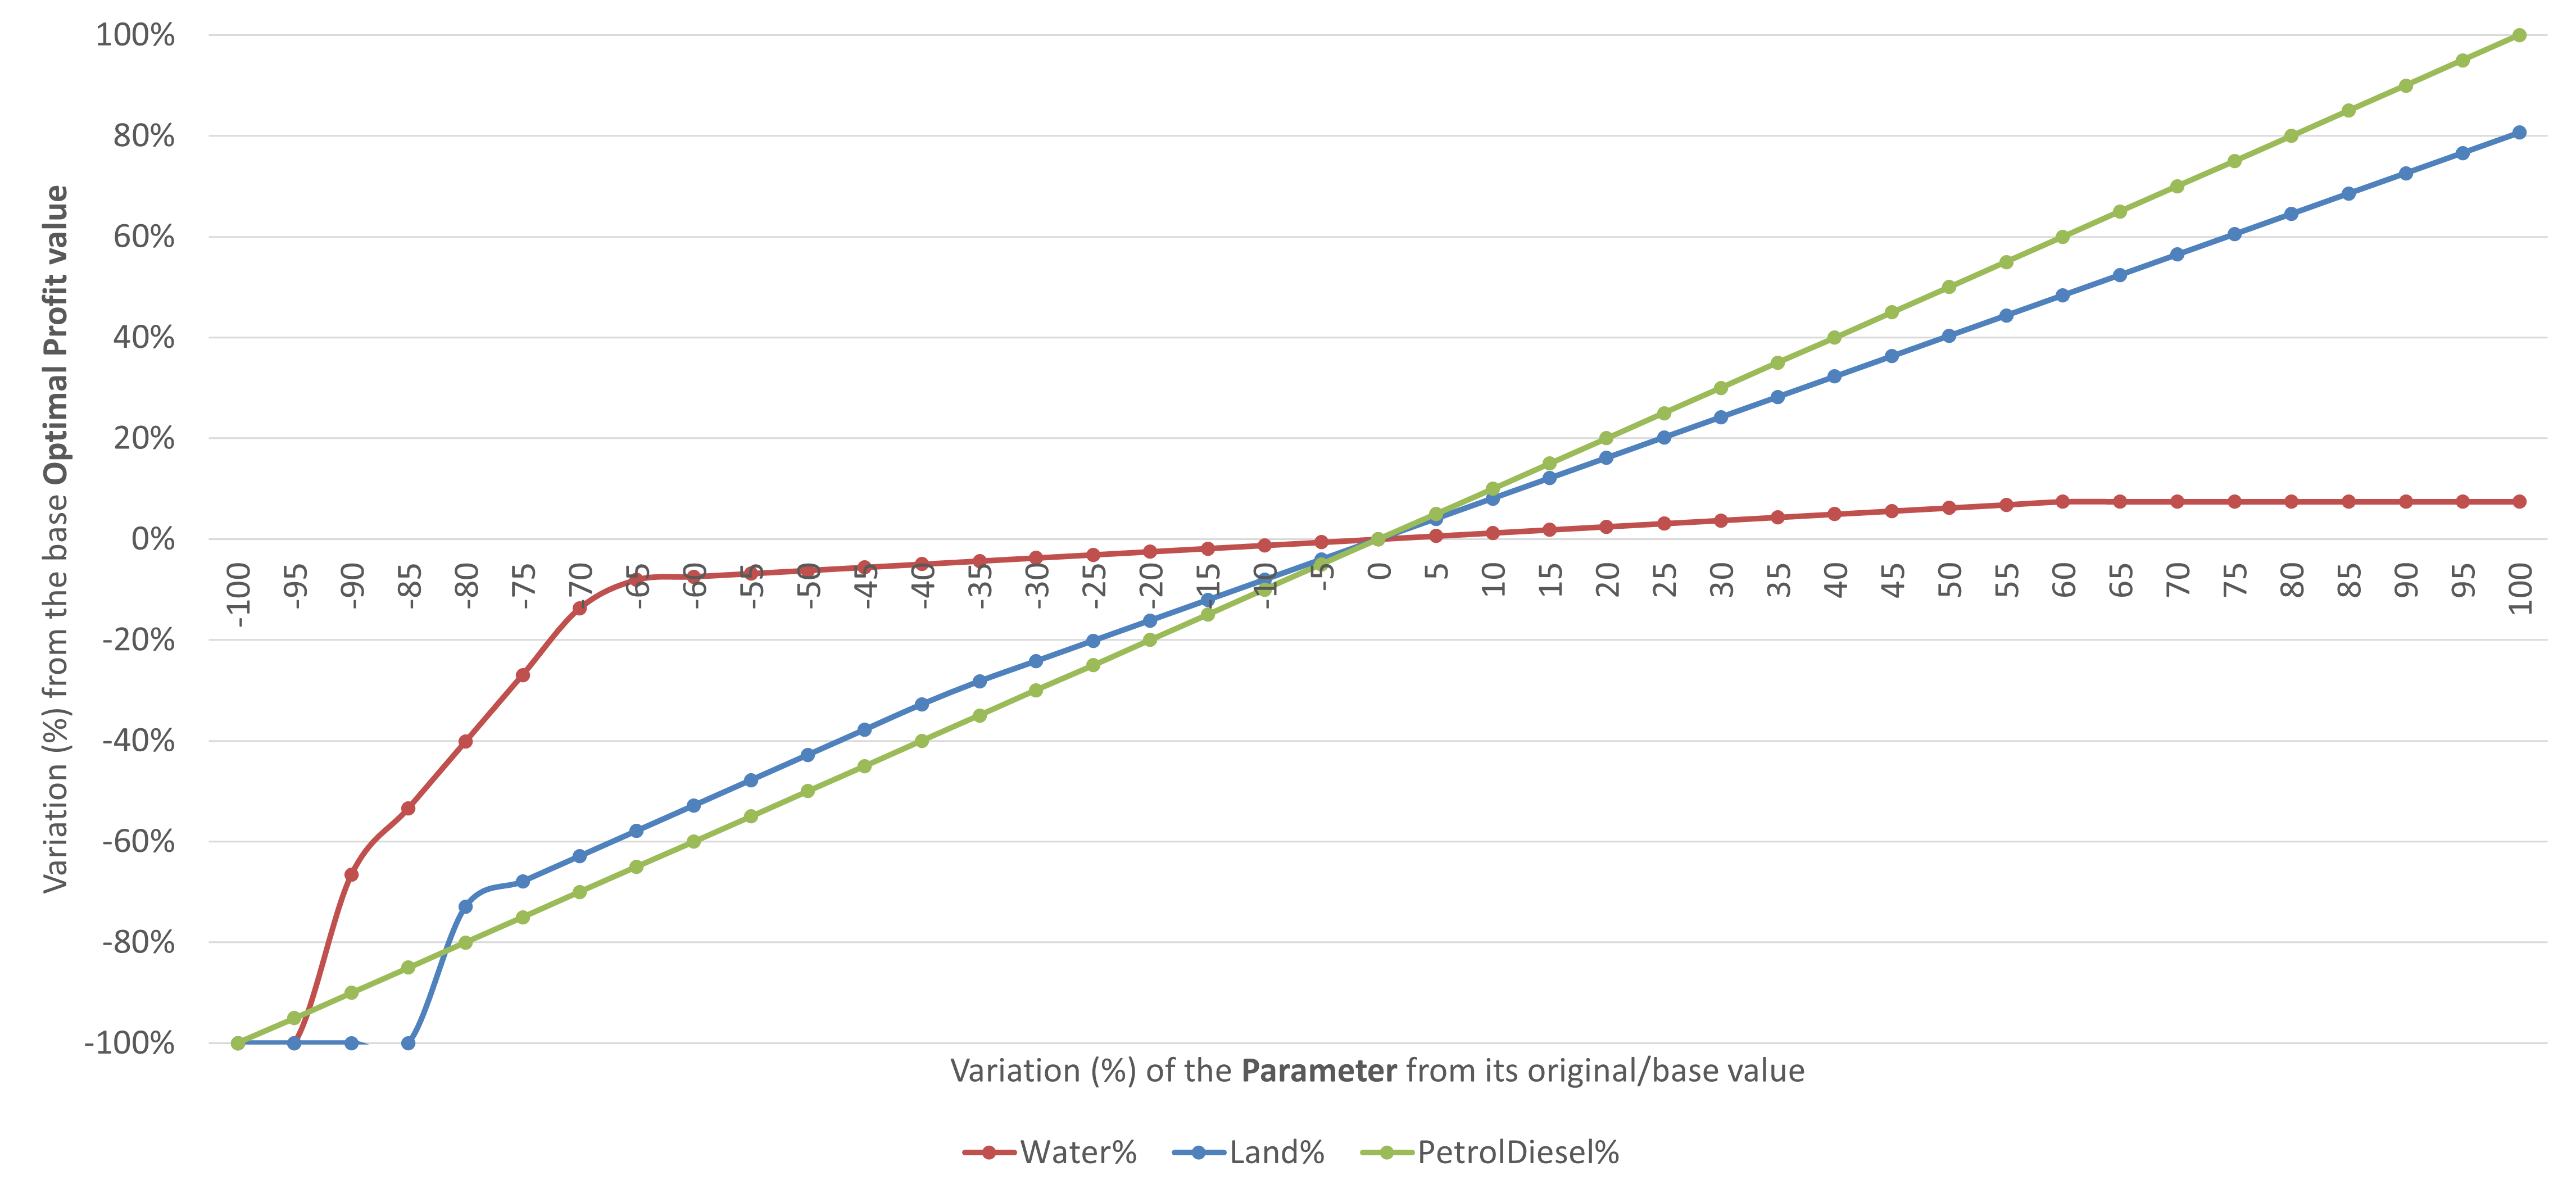

In [51]:
from IPython import display
display.Image("./Graph.png")